In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# from matplotlib_venn import venn2

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, show_pathways_in_ranked_genes, add_pathways_to_deseq_df
from dokdonia.utils import saveToPickleFile, readFromPickleFile, terminal_execute

# plt.style.use('plt_styles.mplstyle')
%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

## Obtain functional annotations

In [2]:
gbk = GenomeGBK(data_dir / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 786 genes


# Load count data

In [3]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv(data_dir / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


# Find DE genes between Light and Dark

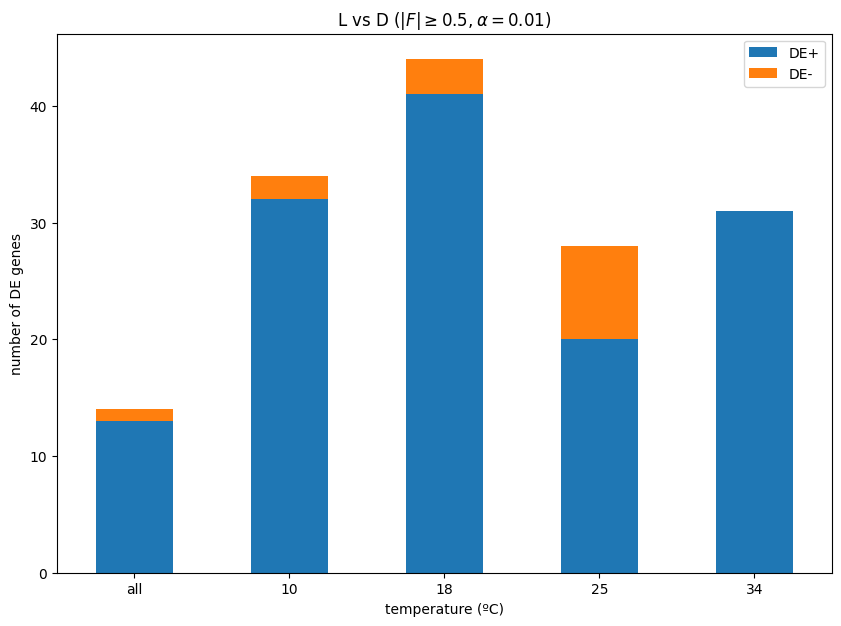

In [4]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [5]:
L_D_stats['18']

{'DE+': 41, 'DE-': 3}

We find DE genes, with a absolute fold cutoff value $|K|\geq0.5$ and significance level $\alpha=0.01$ across all temperatures. In all cases, there are more genes with greater expression under light than those with greater expression in the dark.

Let's look at the lists of DE genes across  temperatures:

In [6]:
# L > D, T = 18 Proteins [Sale alguno en cluster?]
from functools import reduce


DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange >= k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
        'D>L': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange <= -k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
    }


# Find intersections
data_L_D = [DELD[T]["L>D"][["product", "subsystem", "system"]] for T in ['10', '18', '25', '34']]
df_merged_L_D = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_L_D)
# Remove duplicated cols
df_merged_L_D = df_merged_L_D[["product_x", "subsystem_x", "system_x"]]
df_merged_L_D = df_merged_L_D.loc[:, ~df_merged_L_D.columns.duplicated()]
# D - L
data_D_L = [DELD[T]["D>L"][["product", "subsystem", "system"]] for T in ['10', '18', '25', '34']]
df_merged_D_L = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_D_L)
# Remove duplicated cols
df_merged_D_L = df_merged_D_L[["product_x", "subsystem_x", "system_x"]]
df_merged_D_L = df_merged_D_L.loc[:, ~df_merged_D_L.columns.duplicated()]

# Write to Excel
excel_out = results_dir / "deseq_results" / "light_dark_deseq2.xlsx"
with pd.ExcelWriter(excel_out) as writer:  
    for temp, cond_res in DELD.items():
        for cond, df in cond_res.items():
            if "value" in df.columns:
                df = df.rename({"value": "log2FoldChange"}, axis=1)
            df.to_excel(writer, sheet_name=f"{temp}_{cond}")


    df_merged_L_D.to_excel(writer, sheet_name="common_genes_L>D")
    df_merged_D_L.to_excel(writer, sheet_name="common_genes_D>L")

DELD['18']["L>D"].head()

/tmp/ipykernel_32088/2827890644.py:25: FutureWarning: Passing 'suffixes' which cause duplicate columns {'product_x', 'subsystem_x', 'system_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged_L_D = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_L_D)
/tmp/ipykernel_32088/2827890644.py:31: FutureWarning: Passing 'suffixes' which cause duplicate columns {'product_x', 'subsystem_x', 'system_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged_D_L = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_D_L)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,product,subsystem,system
gene_id,,,,,,,,,
MED134_04999,263.884354,1.785131,0.217448,8.209451,2.222013e-16,2.912851e-14,putative cell adhesion protein,Unspecified,Unspecified
MED134_07119,1363.286304,1.726923,0.094093,18.353382,3.101890e-75,8.924138e-72,rhodopsin,Unspecified,Unspecified
MED134_10396,1405.063321,1.657843,0.103206,16.063371,4.608120e-58,4.419187e-55,hypothetical protein,Unspecified,Unspecified
MED134_04009,1408.019749,1.577138,0.088560,17.808788,6.040379e-71,8.689085e-68,ATP-dependent protease La (LON),Unspecified,Unspecified
MED134_07089,392.184936,1.394440,0.125108,11.145931,7.495620e-29,1.797075e-26,sensor of blue-light using FAD,Unspecified,Unspecified


# Effect of temperature on L-D DE genes
How do DE genes across light and dark behave across temperatures?

In [7]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


In [8]:
# Gettranscript/cell dataset
TC = pd.read_csv(data_dir / 'Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC = TC.set_index('index')
TC.index.name = 'ID'

# TC_out = results_dir / "transcript_cell_clust_input.csv"
# TC.to_csv(TC_out)

## DE on multiple comparisons across temperatures
See https://hbctraining.github.io/DGE_workshop/lessons/08_DGE_LRT.html
Fold changes here aren't meaningful.

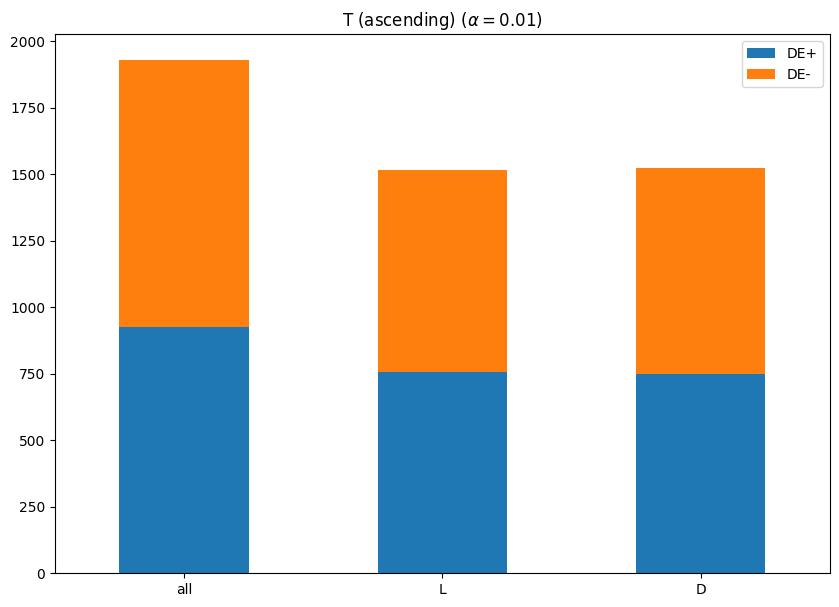

In [9]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

saveToPickleFile(T_res, results_dir / "deseq_results" / "DE_result.pkl")

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

In [10]:
# Write to excel, add pathways
excel_out = results_dir /"deseq_results" / "across_temperature_deseq2.xlsx"
with pd.ExcelWriter(excel_out) as writer:

    for cond, res in T_res.items():
        res = add_pathways_to_deseq_df(
            res,
            gbk,
            gene_pathways,
            gene_systems
            ).drop("log2FoldChange", axis=1)
        res.to_excel(writer, sheet_name=f"{cond}")

In [11]:
# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes which are DE across all temperature values")

There are 1930 out of 2877 genes which are DE across all temperature values


In [12]:
# # Plot L-D Venn diagram
# from matplotlib_venn import venn2

# plt.figure(figsize=(8, 8))
# set1 = set(T_res['L'].index)
# set2 = set(T_res['D'].index)
# Light_specific_DE_genes = set1 - set2
# Dark_specific_DE_genes = set2 - set1
# venn2([set1, set2], ('L', 'D'),
#       set_colors=('purple', 'skyblue'), alpha = 0.7)
# plt.title('DE genes across T (L vs D)')
# plt.show()

# Effect of temperature on gene expression: Pathway enrichment analysis

Next, we analyze the effect that temperature may have on gene expression. To this end, we first cluster genes according to their across-temperature expression pattern, and then perform a permutation-based pathway enrichment analysis to evaluate which pathways are most affected by temperature changes.

To separate the effect of light and dark from that of temperature, we leave out of the analysis the set of genes that were DE between light and dark.

In [13]:
# Remove light-dark DE genes from dataset
TCnoDE = TC.loc[(
    (~TC.index.isin(DE_all_T)) &
    (TC.index.isin(DE_genes_across_T))
    )]

print(f"Number of genes to cluster: {len(TCnoDE)}")

Number of genes to cluster: 1925


# Table of genes which are not affected by temperature

In [14]:
TC_temperature_independent = TC.loc[(
    ~TC.index.isin(DE_genes_across_T)
)]

ranked_series = TC_temperature_independent.median(axis=1).sort_values(ascending=False)
ranked_df = show_pathways_in_ranked_genes(
    ranked_series.to_dict(),
    gbk, gene_pathways,
    gene_systems, n=None
    )

ranked_out_csv = results_dir / "results_temperature_independent" / "temp_independent_genes_avg_expression.csv"
ranked_out_xlsx = results_dir / "results_temperature_independent" / "temp_independent_genes_avg_expression.xlsx"
ranked_df.to_csv(ranked_out_csv)
ranked_df.to_excel(ranked_out_xlsx)

print(f"Number of genes not affected by temperature: {len(TC_temperature_independent)}")


Number of genes not affected by temperature: 947


# Light-Dark DE genes which are also DE across Temperatures (wald + LTR)

In [15]:
DE_D_L_and_across_T = [gene_id for gene_id in DE_all_T if gene_id in DE_genes_across_T]
DE_D_L_and_across_T

['MED134_03404',
 'MED134_10201',
 'MED134_13071',
 'MED134_13076',
 'MED134_14266']

In [16]:
temperatures = [10, 18, 25, 34]
conditions = ["L", "D"]
df = TC.loc[DE_D_L_and_across_T, :]

data = {}
for condition in conditions:
    data[condition] = []
    for temp in temperatures:
        colpattern = f"{condition}_{temp}"
        series = df.loc[:, [col for col in df.columns if colpattern in col]].mean(axis=1)
        series.name = colpattern
        data[condition].append(
            series
            )
        
light_df = pd.DataFrame(data["L"])
light_df.to_excel(results_dir / "results_DE_L_D_and_across_T" / "DE_L_D_and_across_T_light_transcript_cell.xlsx")
dark_df = pd.DataFrame(data["D"])
dark_df.to_excel(results_dir / "results_DE_L_D_and_across_T" / "DE_L_D_and_across_T_dark_transcript_cell.xlsx")

<AxesSubplot: >

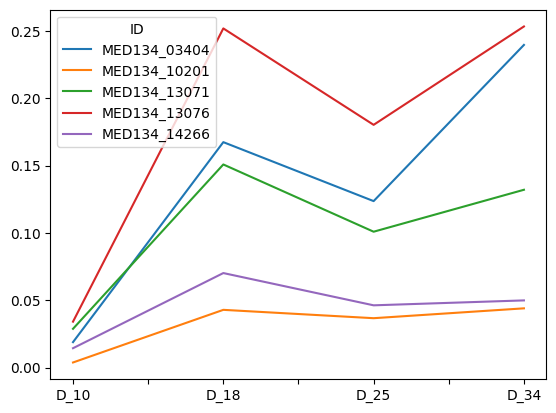

In [17]:
dark_df.plot()

<AxesSubplot: >

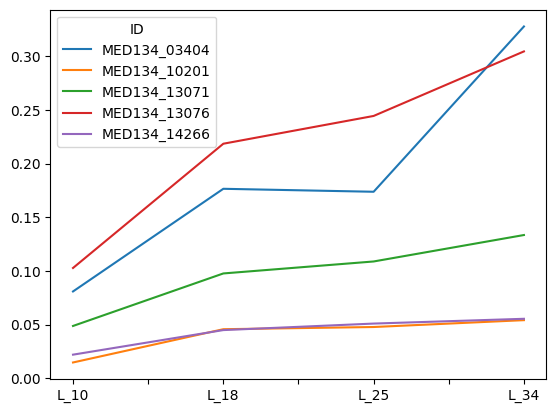

In [18]:
light_df.plot()

In [21]:
# Add pathways
ranked_df = show_pathways_in_ranked_genes(
    light_df.transpose().mean(axis=1).to_dict(),
    gbk, gene_pathways,
    gene_systems, n=None
    )
ranked_df.drop(
    "value", axis=1
    ).to_excel(
    results_dir / "results_DE_L_D_and_across_T" / "DE_L_D_and_acrosss_T.xlsx"
    )

## Cluster by gene expression pattern

In [45]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')

clusters = CA.getGeneClusters(TCnoDE, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1e4)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

# VI.plotClusters(plot_cluster_data, clusters)


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Wednesday 01 March 2023 (13:54:55)                   |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

# Merge clusters:

1. C2 & C3
2. C6 & C7

In [46]:
clusters = {
    "C0": clusters["C0"],
    "C1": clusters["C5"],
    "C2": clusters["C2"] + clusters["C3"],
    "C3": clusters["C6"] + clusters["C7"],
    "C4": clusters["C1"],
    "C5": clusters["C4"]
}

# Merge clusters in Clust output file
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clusters.items() ]))
df = df.applymap(lambda x: "" if pd.isna(x) else x)

with open(results_dir / "clust" / f"{res_id}/Clusters_Objects_merged.tsv", "w+") as file:
    file.write("\t".join([f"{k} ({len(v)} genes)" for k,v in clusters.items()]) + "\n")
    file.write("\t".join(["Genes" for _ in clusters]) + "\n")

    for row in df.values:
        file.write("\t".join(row) + "\n")

n_genes_in_clusters = sum([len(c) for c in clusters.values()])
print(f"There are a total of {n_genes_in_clusters} clustered genes")

There are a total of 1049 clustered genes


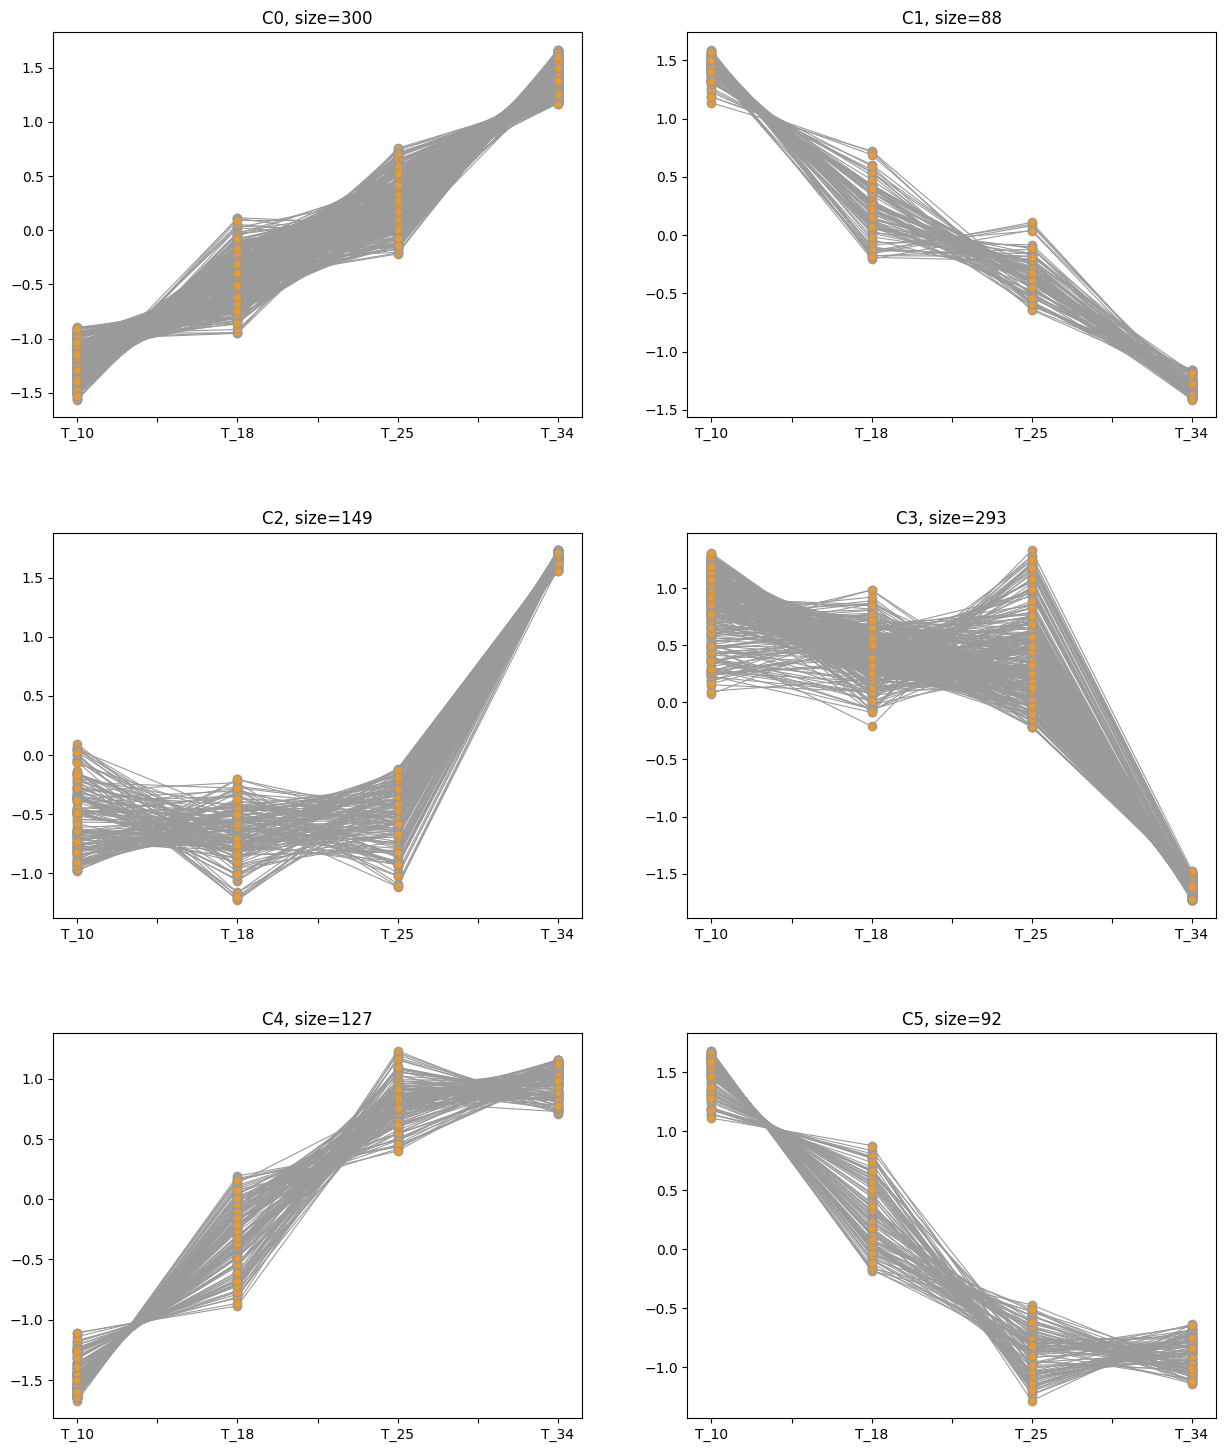

In [44]:
# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(), results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters)

## Rank genes within clusters

Rank genes within clusters by ther silhouette

In [47]:
cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')
ranked_clusters = CA.rankGenesWithinClusters(clusters, cluster_data, method="sil")

cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col='ID')
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters, cluster_data, method="median")

# Gene set enrichment with R

KEGG subsystems

In [48]:
out_dir = results_dir / "enrichment_results"
clusters_path = results_dir / "clust" / f"{res_id}" / "Clusters_Objects_merged.tsv"
stout = terminal_execute(
    command_str=(
    f"Rscript {root_dir / 'dokdonia' / 'clusterProfiler.R'}"
    f" {res_id} {clusters_path} {out_dir}"
    )
)


clusterProfiler v4.6.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter

Warning message:
In compareCluster(geneClusters = cluster_genes, fun = "enrichKEGG",  :
  No enrichment found in any of gene cluster, please check your input...
Error in is.data.frame(x) : 
  trying to get slot "compareClusterResult" from an object of a basic class ("NULL") with no slots
Calls: write.csv ... eval.parent -> eval -> eval -> <Anonymous> -> is.data.frame
Execution halted


In [49]:
# Using R's library ClusterProfiler
df = pd.read_csv(results_dir / f"enrichment_results/results_{res_id}.csv")
df.Cluster = df.Cluster.apply(lambda c: "C" + str(int(c[1]) - 1))
df = df.sort_values(["Cluster", "p.adjust"])
res_df = df[["Cluster", "ID", "Description", "GeneRatio", "pvalue", "p.adjust"]].set_index("Cluster")
res_df.to_csv(results_dir / "enrichment_results" / "cluster_pathways.csv")
res_df

,ID,Description,GeneRatio,pvalue,p.adjust
Cluster,,,,,
C1,dok03018,RNA degradation,3/17,4.917241e-03,8.359310e-02
C2,dok00630,Glyoxylate and dicarboxylate metabolism,5/26,1.606406e-03,4.337297e-02
C2,dok01120,Microbial metabolism in diverse environments,9/26,7.247885e-03,7.417934e-02
C2,dok00020,Citrate cycle (TCA cycle),3/26,9.263899e-03,7.417934e-02
C2,dok01200,Carbon metabolism,7/26,1.098953e-02,7.417934e-02
C3,dok03010,Ribosome,21/93,3.068008e-10,1.104483e-08
C5,dok00220,Arginine biosynthesis,5/20,1.248969e-05,2.872630e-04
C5,dok01230,Biosynthesis of amino acids,7/20,2.606635e-03,2.430773e-02
C5,dok01210,2-Oxocarboxylic acid metabolism,4/20,3.170574e-03,2.430773e-02


# Describing ranked genes

In [ ]:
# ranked_df = show_pathways_in_ranked_genes(
#     ranked_clusters["C0"],
#     gbk, gene_pathways,
#     gene_systems, n=10
#     )
# ranked_df

In [ ]:
# no_kegg_pathway = []
# for cluster_id in ranked_clusters_avg_expr:
#     ranked_df = show_pathways_in_ranked_genes(
#         ranked_clusters_avg_expr[cluster_id],
#         gbk, gene_pathways,
#         gene_systems, n=None
#         )
#     no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
#     ranked_df = ranked_df[~(
#         (ranked_df["product"].str.contains("hypothetical")) &
#         (ranked_df["subsystem"].str.contains("Unspecified"))
#         )]
#     ranked_df.to_csv(f"ranked_{cluster_id}.csv")

# print(no_kegg_pathway)
# print(np.mean(no_kegg_pathway))

# Ranked lists among the global 10% by expression

In [50]:
percent_cutoff = 10

filtered_ranked_clusters = {}

all_genes_expression = {gene: expr for cluster in ranked_clusters_avg_expr.values() for gene, expr in cluster.items()}

sorted_all_genes_expression = sorted(all_genes_expression.items(), key=lambda x:x[1], reverse=True)
sorted_all_genes_expression = dict(sorted_all_genes_expression)

cutoff_position = int( (10 / 100) * len(sorted_all_genes_expression) )
cutoff_value = list(sorted_all_genes_expression.values())[cutoff_position]
print(f"Cutoff average expression value of: {cutoff_value} transcript/cell")
top_genes = list(sorted_all_genes_expression.keys())[:cutoff_position]

for cluster_id, cluster in ranked_clusters_avg_expr.items():
    filtered_ranked_clusters[cluster_id] = {gene: expr for gene, expr in cluster.items() if gene in top_genes}

Cutoff average expression value of: 3782.404166080809 transcript/cell


In [51]:
no_kegg_pathway = []
for cluster_id in filtered_ranked_clusters:
    ranked_df = show_pathways_in_ranked_genes(
        filtered_ranked_clusters[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    # ranked_df = ranked_df[~(
    #     (ranked_df["product"].str.contains("hypothetical")) &
    #     (ranked_df["subsystem"].str.contains("Unspecified"))
    #     )]
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}.csv")

print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))